## Compare ChebyKAN's ability in function interpolation with MLP

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/KAN/ChebyKAN/')  # Add the directory to Python's path




Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from ChebyKANLayer import ChebyKANLayer

In [4]:
# Define target function (piecewise function)
def target_function(x):
    y = np.zeros_like(x)
    mask1 = x < 0.5
    y[mask1] = np.sin(20 * np.pi * x[mask1]) + x[mask1] ** 2
    mask2 = (0.5 <= x) & (x < 1.5)
    y[mask2] = 0.5 * x[mask2] * np.exp(-x[mask2]) + np.abs(np.sin(5 * np.pi * x[mask2]))
    mask3 = x >= 1.5
    y[mask3] = np.log(x[mask3] - 1) / np.log(2) - np.cos(2 * np.pi * x[mask3])

    # add noise
    noise = np.random.normal(0, 0.1, y.shape)
    y_noise = y + noise

    return y, y_noise

In [17]:
# Define target function (sqrt(x))
def target_function(x):
    y = np.zeros_like(x)
    mask1 = x < 0
    y[mask1] = 0
    mask2 = x >= 0
    y[mask2] = np.sqrt(x[mask2])


    # add noise
    noise = np.random.normal(0, 0.1, y.shape)
    y_noise = y + noise

    return y, y_noise

In [22]:
# Define target function (x**0.5 * (1-x)**(3/4))
def target_function(x):
    y = np.zeros_like(x)
    mask1 = x < 0
    y[mask1] = 0
    mask2 = (0 <= x) & (x <= 1)
    y[mask2] = x[mask2]**0.5 * (1-x[mask2])**(3/4)
    mask3 = x > 1
    y[mask3] = 0


    # add noise
    noise = np.random.normal(0, 0.1, y.shape)
    y_noise = y + noise

    return y, y_noise

In [27]:
# Define target function (exp(-x/0.01))
def target_function(x):
    y = np.zeros_like(x)
    mask1 = x >= 0
    y[mask1] = np.exp(-x[mask1]/0.01)




    # add noise
    noise = np.random.normal(0, 0.1, y.shape)
    y_noise = y + noise

    return y, y_noise

In [28]:
# Define MLP and ChebyKAN
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 128),
            nn.Tanh(),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        return self.layers(x-1) # centralize the input


class ChebyKAN(nn.Module):
    def __init__(self):
        super(ChebyKAN, self).__init__()
        self.chebykan1 = ChebyKANLayer(1, 44, 44)
        self.chebykan2 = ChebyKANLayer(44, 1, 44)

    def forward(self, x):
        x = self.chebykan1(x)
        x = self.chebykan2(x)
        return x

In [29]:
# Generate sample data
x_train = torch.linspace(0, 2, steps=500).unsqueeze(1)
y_target, y_train = target_function(x_train)
y_target, y_train = torch.tensor(y_target, dtype = torch.float32), torch.tensor(y_train, dtype = torch.float32)

# Instantiate models
cheby_model = ChebyKAN()
mlp_model = SimpleMLP()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer_cheby = torch.optim.Adam(cheby_model.parameters(), lr=0.01)
optimizer_mlp = torch.optim.Adam(mlp_model.parameters(), lr=0.03)

cheby_losses = []

mlp_losses = []


# Train the models
epochs = 2000
for epoch in range(epochs):
    optimizer_cheby.zero_grad()
    outputs_cheby = cheby_model(x_train)
    loss_cheby = criterion(outputs_cheby, y_train)
    loss_cheby_gen = criterion(outputs_cheby, y_target)
    loss_cheby.backward()
    optimizer_cheby.step()

    optimizer_mlp.zero_grad()
    outputs_mlp = mlp_model(x_train)
    loss_mlp = criterion(outputs_mlp, y_train)
    loss_mlp_gen = criterion(outputs_mlp, y_target)
    loss_mlp.backward()
    optimizer_mlp.step()

    if epoch % 100 == 0:
        cheby_losses.append(loss_cheby.item())
        mlp_losses.append(loss_mlp.item())
        print(f'Epoch {epoch + 1}/{epochs}, ChebyKAN training Loss: {loss_cheby.item():.4f}, MLP training Loss: {loss_mlp.item():.4f}')
        print(f'Epoch {epoch + 1}/{epochs}, ChebyKAN generalization Loss: {loss_cheby_gen.item():.4e}, MLP generalization Loss: {loss_mlp_gen.item():.4e}')
        print()
# Test the models
x_test = torch.linspace(0, 2, steps=400).unsqueeze(1)
y_pred_cheby = cheby_model(x_test).detach()
y_pred_mlp = mlp_model(x_test).detach()

Epoch 1/2000, ChebyKAN training Loss: 0.0124, MLP training Loss: 0.0286
Epoch 1/2000, ChebyKAN generalization Loss: 3.8816e-03, MLP generalization Loss: 1.9973e-02

Epoch 101/2000, ChebyKAN training Loss: 0.0027, MLP training Loss: 0.0120
Epoch 101/2000, ChebyKAN generalization Loss: 6.4045e-03, MLP generalization Loss: 3.4278e-03

Epoch 201/2000, ChebyKAN training Loss: 0.0019, MLP training Loss: 0.0119
Epoch 201/2000, ChebyKAN generalization Loss: 6.3769e-03, MLP generalization Loss: 3.3608e-03

Epoch 301/2000, ChebyKAN training Loss: 0.0016, MLP training Loss: 0.0118
Epoch 301/2000, ChebyKAN generalization Loss: 6.4835e-03, MLP generalization Loss: 3.2948e-03

Epoch 401/2000, ChebyKAN training Loss: 0.0030, MLP training Loss: 0.0117
Epoch 401/2000, ChebyKAN generalization Loss: 7.9522e-03, MLP generalization Loss: 3.2319e-03

Epoch 501/2000, ChebyKAN training Loss: 0.0025, MLP training Loss: 0.0117
Epoch 501/2000, ChebyKAN generalization Loss: 7.8787e-03, MLP generalization Loss: 3.

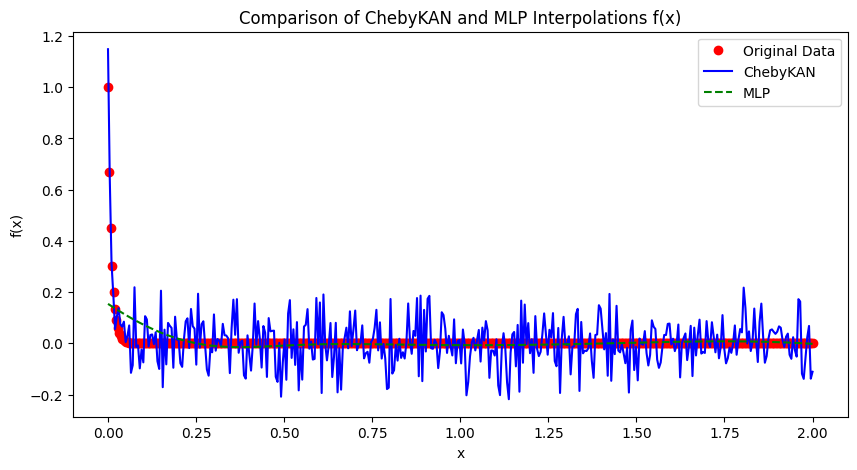

In [30]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(x_train.numpy(), y_target.numpy(), 'ro', label='Original Data')
plt.plot(x_test.numpy(), y_pred_cheby.numpy(), 'b-', label='ChebyKAN')
plt.plot(x_test.numpy(), y_pred_mlp.numpy(), 'g--', label='MLP')
plt.title('Comparison of ChebyKAN and MLP Interpolations f(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

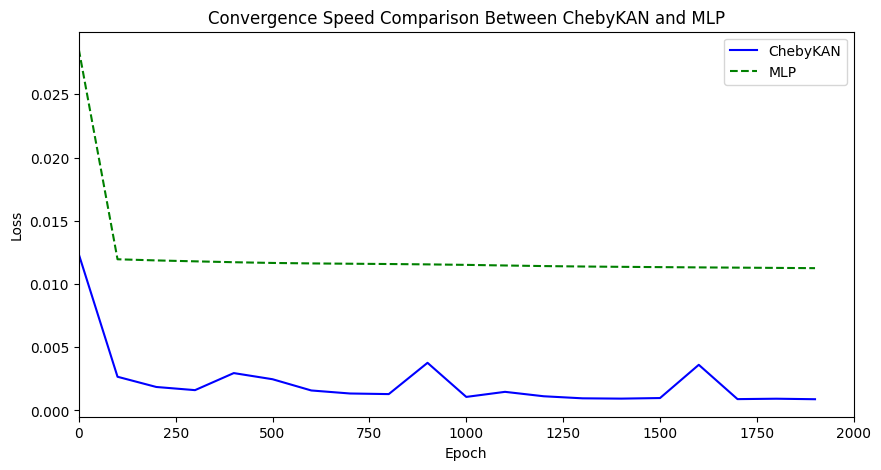

In [31]:
# Plot the convergence speed
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 100), cheby_losses, 'b-', label='ChebyKAN')
plt.plot(range(0, epochs, 100), mlp_losses, 'g--', label='MLP')
plt.title('Convergence Speed Comparison Between ChebyKAN and MLP')
plt.xlim(0, 2000)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()